# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
# Your code here
# libraries
import jedi
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_profiling
import pygments
import re
import seaborn as sns
from scipy import stats as st
import sklearn
from sklearn.datasets import load_boston
from tqdm import tqdm
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
# Versions
print("jedi version:", jedi.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("Pygments version:", pygments.__version__)
print("re version:", re.__version__)
print("Seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)

jedi version: 0.16.0
numpy version: 1.18.1
pandas version: 1.0.1
Pygments version: 2.5.2
re version: 2.2.1
Seaborn version: 0.10.0
sklearn version: 0.22.1


In [3]:
# Directories & Files
os.listdir()

# Datasets directory
directory = "../data/"

In [4]:
#creating the dataframe
boston_df = pd.read_csv(directory + "boston_data.csv")

# checking the df
boston_df.head()
boston_df.info() # There aren't nulls - recheck! There are a lot of 0's :'(
round(boston_df.describe(), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     404 non-null    float64
 1   zn       404 non-null    float64
 2   indus    404 non-null    float64
 3   chas     404 non-null    float64
 4   nox      404 non-null    float64
 5   rm       404 non-null    float64
 6   age      404 non-null    float64
 7   dis      404 non-null    float64
 8   rad      404 non-null    float64
 9   tax      404 non-null    float64
 10  ptratio  404 non-null    float64
 11  black    404 non-null    float64
 12  lstat    404 non-null    float64
 13  medv     404 non-null    float64
dtypes: float64(14)
memory usage: 44.3 KB


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,3.73,10.51,11.19,0.07,0.56,6.30,68.60,3.80,9.84,411.69,18.44,355.07,12.60,22.31
std,8.94,22.05,6.81,0.25,0.12,0.68,28.07,2.11,8.83,171.07,2.15,94.49,6.93,8.84
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.17,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.90,45.80,2.09,4.00,281.00,17.38,374.71,7.14,17.10
50%,0.25,0.00,9.80,0.00,0.54,6.23,76.60,3.21,5.00,330.00,19.00,391.06,11.26,21.40
75%,4.05,12.50,18.10,0.00,0.63,6.63,94.15,5.22,24.00,666.00,20.20,396.01,16.91,25.00
max,88.98,95.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,34.37,50.00


In [5]:
# checking columns that have 0's in them
for col in boston_df.columns:
    if (0 in boston_df[col].values) == True:
        print(col)
        print(boston_df[col].value_counts(), f"\n")
        
# So... now I don't understand if these are NaN's or not. I don't know if it makes sense for 
# ZN (proportion of residential land zoned for lots over 25,000 sq.ft.) to have so many 0's,
# nor in CHAS (Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)).
# It 'feels' :\ like it does (on CHAS), and it might on ZN anyway, so I'll keep everything
# as is.

zn
0.0     300
20.0     15
12.5     10
80.0     10
22.0      9
25.0      8
30.0      6
40.0      5
45.0      4
60.0      4
21.0      3
75.0      3
52.5      3
34.0      3
33.0      3
95.0      3
28.0      2
82.5      2
90.0      2
70.0      2
85.0      2
55.0      2
17.5      1
35.0      1
18.0      1
Name: zn, dtype: int64 

chas
0.0    376
1.0     28
Name: chas, dtype: int64 



In [6]:
# removing outliers
# check for outliers percentage in each column based on IQR
for col in boston_df.columns[1:]:
    Q1 = boston_df[col].quantile(0.25)
    Q3 = boston_df[col].quantile(0.75)
    IQR = Q3 - Q1 
    n_outliers = len([i for i in boston_df[col] 
                      if (i < Q1 - 1.5 * IQR) | (i > Q3 + 1.5 * IQR)])
    
    print(col, round(n_outliers / len(boston_df) * 100, 2),"%")

#remove outliers based on z score above 3 == values beyond 3 std.dev from the mean both sides.
boston_clean  = boston_df[(np.abs(st.zscore(boston_df.loc[:, 
                                                          boston_df.columns != "chas"])) 
                           < 3).all(axis = 1)]

# checking that there was no interference with the bool values in chas
boston_clean[boston_clean["chas"] == 1]

# cheking how many values where droped
len(boston_df) - len(boston_clean)

zn 12.13 %
indus 0.0 %
chas 6.93 %
nox 0.0 %
rm 5.2 %
age 0.0 %
dis 1.24 %
rad 0.0 %
tax 0.0 %
ptratio 2.97 %
black 15.1 %
lstat 0.5 %
medv 6.68 %


60

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

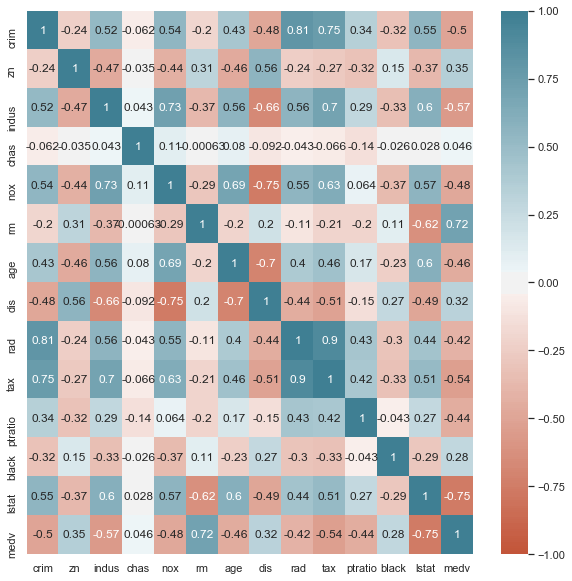

In [7]:
# Your plots here

# I'm doing a correlation matrix so that I don't have to guess. The alternative would be 
# checking all, which, in this case, is feasable.

# correlation matrix to prepare the heatmap
corr_matrix = boston_clean.corr()

# to print the heatmap
%matplotlib inline

# creating the heatmap to check the variables most correlated with the prices of homes in 
# Boston (medv)
sns.set("notebook")
fig, ax = plt.subplots(figsize = (10, 10)) 
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix, square = False, fmt = ".2g", vmin = -1, vmax = 1, 
                     center = 0, cmap = sns.diverging_palette(20, 220, n = 200), 
                     annot = True)

#round(corr_matrix, 2)

# lstat has a reasonable high negative correlation with medv, and rm also has a reasonable 
# high (positive) correlation with medv, so they're probably the best to plot?

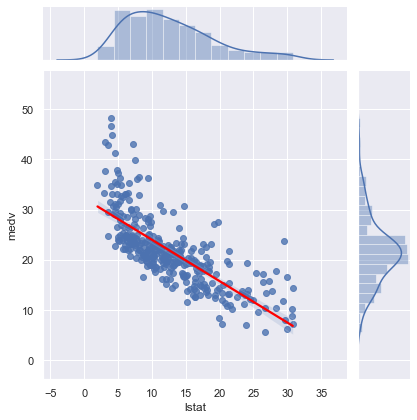

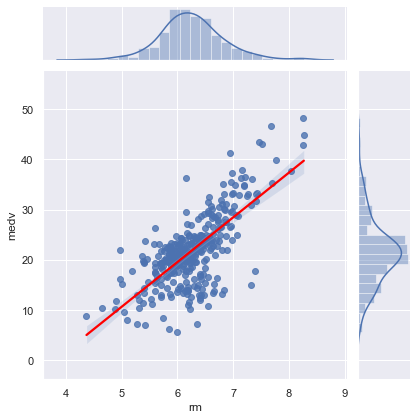

In [8]:
# creating plots that show the data dispersion as well as the regression line of best fit for
# each column
for col in boston_clean[["lstat", "rm"]]:
    %matplotlib inline
    
    #sns.set_style("ticks")
    sns.set()
    scat = sns.jointplot(x = col, y = "medv", data = boston_clean, kind = "reg")#.set_title(f"{col} // medv")
    line = scat.ax_joint.get_lines()[0]
    line.set_color("red")

    plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [9]:
# Your response here
"""
Are these the relationships you expected to see in these variables?
    After looking at the correlation matrix, just about, yes. 

What do these plots tell you about the relationships between these variables and the prices 
of homes in Boston?
    That there is a reasonable relation..?
"""

'\nAre these the relationships you expected to see in these variables?\n    After looking at the correlation matrix, just about, yes. \n\nWhat do these plots tell you about the relationships between these variables and the prices \nof homes in Boston?\n    That there is a reasonable relation..?\n'

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [10]:
# Your response here
"""
(plotted above)
Among themselves? There are a few, like crim and rad, or tax and indu. With medv, not really,
no, but that's because 1) I had done the heatmap before the regplots and, 2) below .60 I, as
a rule of thumb, don't consider to be too correlated at all (high, for me would be .75/.80+,
but I realise that different fields/people have different criteria).
"""

"\n(plotted above)\nAmong themselves? There are a few, like crim and rad, or tax and indu. With medv, not really,\nno, but that's because 1) I had done the heatmap before the regplots and, 2) below .60 I, as\na rule of thumb, don't consider to be too correlated at all (high, for me would be .75/.80+,\nbut I realise that different fields/people have different criteria).\n"

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [19]:
# Your code here
round(boston_df["medv"].describe(), 2)

count    404.00
mean      22.31
std        8.84
min        5.00
25%       17.10
50%       21.40
75%       25.00
max       50.00
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [21]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [23]:
# Your code here
from sklearn.model_selection import train_test_split

y = boston_df["medv"]
X = boston_df.drop(labels = "medv", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [41]:
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor

# defining each depth to try
depths = [2, 4, 6, 8, 10]

# initializing lists to keep the scores
train_scores = list()
test_scores = list()

# testing
for d in depths:
    # initializing model
    rfr = RandomForestRegressor(max_depth = d)
    
    # fiting
    rfr.fit(X_train, y_train)
    
    # predicting train
    y_pred_train = rfr.predict(X_train)
    
    # predicting test
    y_pred_test = rfr.predict(X_test)
    
    # Scoring the tests
    train_score = performance_metric(y_train, y_pred_train)
    test_score = performance_metric(y_test, y_pred_test)

    train_scores += [train_score]
    test_scores += [test_score]

In [42]:
train_scores
test_scores

[0.6029402509185857,
 0.6778877115050628,
 0.7202060898333514,
 0.7366544769602794,
 0.7284505467346035]

Now, plot the score for each tree on the training set and on the testing set.

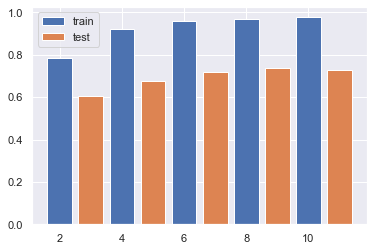

In [51]:
# Produce a plot with the score for the testing and training for the different max depths
# ploting train scores
# to plot within jupyter
%matplotlib inline

# setting background to white
plt.figure(facecolor = "w")

# plotting train scores
plt.bar(x = depths, height = train_scores, label = "train")

# ploting test scores
plt.bar(x = [d + 1 for d in depths], height = test_scores, label = "test")

# generating legend
plt.legend()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [52]:
# Your response here
"""
After (including) a depth of 6, the gains are marginal at best (and if you look at the 
numbers, you actually lose).
"""

'\nAfter (including) a depth of 6, the gains are marginal at best (and if you look at the \nnumbers, you actually lose).\n'

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [ ]:
# Your response here
"""
Random Forests are 'ensembles bagging techniques' where a number of decision trees combine 
(into a forest) to make the final prediction. The process is a combination of bootstrapping 
and aggregation, where the main idea is that having many of high variance and low bias trees
combined, will generate low bias and low variance predictions.

This makes Random Forests robust to under and over fitting.

If I'm getting the RFR model correctly, a maximum depth of 1 suffers from high bias. 
With a maximum depth of 10, suffers from high variance.

    «max_depth
    max_depth is the how many splits deep you want each tree to go. max_depth = 50, for 
    example, would limit trees to at most 50 splits down any given branch. This has the 
    consequence that our Random Forest can no more fit the training data as closely, and is 
    consequently more stable. It has lower variance, giving our model lower error. Remember 
    that even though severely constraining max_depth could increase the bias of each tree 
    given that they may not be able to capture certain patterns in the data before hitting 
    their limit, we need not worry about this. A suitable choice of n_estimators, coupled 
    with bagging, ensures that the bias of the forest as a whole doesn’t increase in the 
    process.
    
    max_depth is a hyperparameter that I typically leave untouched simply because what I 
    really care about is how many observations are at the end of a branch before I forbid 
    the tree from splitting further. This is a better predictor of how overfit the Random 
    Forest is.»

More: https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4
(also: https://olegleyz.github.io/boston_housing.html, where, I suspect, this exercise was
adapted from.)
"""

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [77]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV, ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], test_size = 0.20, random_state = 0)
    print (cv_sets)
    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {"max_depth": range(1, 11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, 
                        cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [82]:
# Your response here
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print(f"\nParameter 'max_depth' is {reg.get_params()['max_depth']} for the optimal model.")

ShuffleSplit(n_splits=323, random_state=0, test_size=0.2, train_size=None)

Parameter 'max_depth' is 5 for the optimal model.


### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [83]:
# Your response here
"""
This model *should NOT* be used in the real life.

1) The data from 1978 can only be relevant today if used for and in its historical context.

2) This data has not only racial and economic prejudices built into it that would bias the 
model, it also does not contemplate more current concerns when looking for a house, and I'm
unsure if had the most up-to-date concerns of that time.

3) It depends on how you're evaluating this. It might. But consistency is not accuracy, 
precision nor applicability. We could do better today.

4) This is an interesting question. I would hypothetise that it is not, but proper a study 
could be engineered to answer this adequatly.

"""

"\nThis model *should NOT* be used in the real life.\n\n1) The data from 1978 can only be relevant today if used for and in its historical context.\n\n2) This data has not only racial and economic prejudices built into it that would bias the \nmodel, it also does not contemplate more current concerns when looking for a house, and I'm\nunsure if had the most up-to-date concerns of that time.\n\n3) It depends on how you're evaluating this. It might. But consistency is not accuracy, \nprecision nor applicability. We could do better today.\n\n4) This is an interesting question. I would hypothetise that it is not, but proper a study \ncould be engineered to answer this adequatly.\n\n"